## Background

You will use the data contained in the train.csv file to train a model that will predict **dissolved inorganic carbon (DIC)** content in the water samples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as keras
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Normalization

2024-03-20 00:55:35.288753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 00:55:35.401539: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 00:55:35.405444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.2.2/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/j

In [2]:
# Turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set seed
np.random.seed(123)


In [3]:
# Import data
train_df = pd.read_csv('data/train.csv')
train_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

# Data exploration
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1454 non-null   int64  
 1   lat_dec            1454 non-null   float64
 2   lon_dec            1454 non-null   float64
 3   no2um              1454 non-null   float64
 4   no3um              1454 non-null   float64
 5   nh3um              1454 non-null   float64
 6   r_temp             1454 non-null   float64
 7   r_depth            1454 non-null   int64  
 8   r_sal              1454 non-null   float64
 9   r_dynht            1454 non-null   float64
 10  r_nuts             1454 non-null   float64
 11  r_oxy_micromol.kg  1454 non-null   float64
 12  unnamed:_12        0 non-null      float64
 13  po4um              1454 non-null   float64
 14  sio3um             1454 non-null   float64
 15  ta1.x              1454 non-null   float64
 16  salinity1          1454 

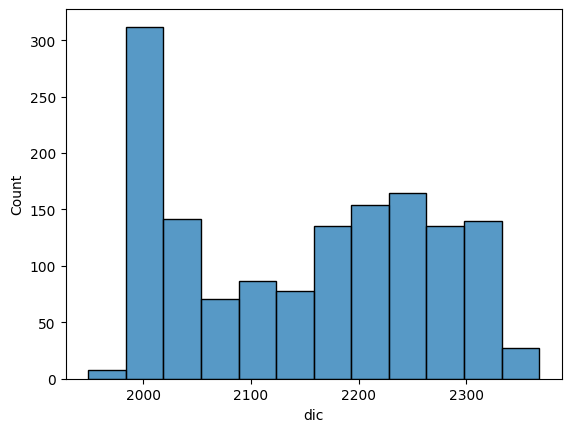

In [4]:
# Check distribution of outcome variable
sns.histplot(train_df['dic'], kde=False)
plt.show()


## Preprocess

In [5]:
# Remove 'id' and 'unnamed:_12' columns (for reasons specified above)
train_df = train_df.drop(['id', 'unnamed:_12'], axis=1)

## Build & train model

## Predict testing data

In [6]:
# Import data
test_df = pd.read_csv('data/test.csv')
test_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

# Data exploration
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat_dec            485 non-null    int64  
 1   lon_dec            485 non-null    float64
 2   no2um              485 non-null    float64
 3   no3um              485 non-null    float64
 4   nh3um              485 non-null    float64
 5   r_temp             485 non-null    float64
 6   r_depth            485 non-null    float64
 7   r_sal              485 non-null    int64  
 8   r_dynht            485 non-null    float64
 9   r_nuts             485 non-null    float64
 10  r_oxy_micromol.kg  485 non-null    float64
 11  po4um              485 non-null    float64
 12  sio3um             485 non-null    float64
 13  ta1.x              485 non-null    float64
 14  salinity1          485 non-null    float64
 15  temperature_degc   485 non-null    float64
 16  dic                485 non

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.regularizers import l1


# Turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set seed
np.random.seed(123)

# Import data
train_df = pd.read_csv('data/train.csv')
train_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

# Remove 'id' and 'unnamed:_12' columns (for reasons specified above)
train_df = train_df.drop(['id', 'unnamed:_12'], axis=1)

# define feature matrix
X = train_df.drop('dic', axis=1).values

# define target vector
y = train_df['dic'].values

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=456)

# Create a Normalization layer
#normalizer = Normalization(axis = -1, input_shape = (X_train.shape[1],))

# Define model architecture
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(l1=0.01)),
    Dense(64, activation='relu', kernel_regularizer=l1(l1=0.01)),
    Dense(1, activation='linear')])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0000001),
              loss='mean_squared_error')

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,  # Number of epochs with no improvement
                               verbose=0,
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric.

# Set up ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.h5',  # Path to save the model file
                                   monitor='val_loss',  # Monitor validation loss
                                   verbose=0,
                                   save_best_only=True)  # Save only the best model

# Train the model with callbacks
model_fit = model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=10,
                      validation_data=(X_val, y_val),
                      verbose=0,
                      callbacks=[early_stopping, model_checkpoint])  # Add callbacks here

In [28]:
from tensorflow.keras.models import load_model

# Load the saved best model with the custom layer explicitly specified
loaded_model = load_model('best_model.h5')


In [29]:
# Evaluate the model on the normalized validation or test data
mse = loaded_model.evaluate(X_val, y_val, verbose=0)
print(f"Mean Squared Error (MSE) on Validation Data: {mse}")


Mean Squared Error (MSE) on Validation Data: 3094933.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [40]:
import keras
def create_model(neurons, activation, optimizer, learning_rate, batch_size, epochs):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, activation=activation, input_shape=(train_df.shape[1],)))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    model.fit(train_df, train_df[:, -1], batch_size=batch_size, epochs=epochs)
    return model

In [41]:
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

/opt/python/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [42]:
param_space = {
    'neurons': [32, 64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [10**-6, 10**-5, 10**-4],
    'batch_size': [32, 64, 128],
    'epochs': [100, 200, 300]
}

In [44]:
from sklearn.model_selection import GridSearchCV

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

grid_search = GridSearchCV(model, param_space, cv=5)
grid_search.fit(X_train, y_train)

/opt/python/3.7.13/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1620 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/python/3.7.13/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/linusghanadan/.local/lib/python3.7/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "/tmp/ipykernel_1209343/156051688.py", line 7, in create_model
    model.fit(train_df, train_df[:, -1], 

TypeError: '(slice(None, None, None), -1)' is an invalid key

In [ ]:
print(grid_search.best_params_)